# CAM을 만들고 평가해 보자

## 1. 라이브러리 버전 확인하기

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import PIL

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.6.0
1.21.4
4.5.3
8.3.2


In [2]:
# 라이브러리 불러오기
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print('완료')

완료


In [3]:
# gpu 확인하기
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# 데이터 불러오기
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('완료')

완료


In [5]:
# 데이터셋의 메타 정보인 df_info를 조회해 features가 어떻게 구성되어 있는지 확인하기
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [6]:
# 데이터셋의 클래스 수
num_classes = ds_info.features["label"].num_classes
print(num_classes)

120


## 3. Grad-CAM 구현하기
1. 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요
2. 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요
3. 위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요

In [20]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# VGG18 모델 구현
def build_vgg18(input_shape=(224, 224, 3), num_classes=120):
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Global Average Pooling Layer
    x = GlobalAveragePooling2D()(x)

    # Dense Layer for classification
    outputs = Dense(num_classes, activation='softmax', use_bias=False)(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# VGG18 모델 생성
vgg18_model = build_vgg18(input_shape=(224, 224, 3), num_classes=120)

# 모델 요약 출력 (필요 시)
vgg18_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 56, 56, 128)       0   

In [27]:
def normalize_and_resize_img(input):
    # 이미지 데이터 정규화 및 크기 조정
    # 'uint8' 데이터를 'float32'로 변환하고 크기를 224x224로 조정
    image = tf.image.resize(input['image'], [224, 224])  # 이미지를 224x224 크기로 조정
    input['image'] = tf.cast(image, tf.float32) / 255.0  # uint8(0~255) 데이터를 float32(0~1)로 정규화
    return input['image'], input['label']  # 정규화된 이미지와 레이블을 반환

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    # 데이터셋에 정규화 및 배치 처리 적용
    ds = ds.map(
        normalize_and_resize_img,  # 데이터셋의 각 이미지를 정규화 및 크기 조정
        num_parallel_calls=2       # 병렬로 데이터를 2개의 코어에서 처리
    )
    ds = ds.batch(batch_size)      # 지정된 크기만큼 배치로 묶음
    
    '''
    # 테스트 데이터가 아닌 경우 데이터 반복 및 셔플링
    if not is_test:
        ds = ds.repeat()           # 데이터셋을 무한 반복 (모델 학습 시 사용)
        ds = ds.shuffle(200)       # 200개의 버퍼 크기로 데이터 셔플링
    '''
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)  # 데이터 로드와 학습을 병렬 처리하여 성능 최적화
    return ds  # 처리된 데이터셋 반환

print('완료')

완료


In [28]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [23]:
# 학습하기
vgg18_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=1),
    metrics=['accuracy'],
)

history_vgg18_model = vgg18_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 196s 260ms/step - loss: 4.7887 - accuracy: 0.0095 - val_loss: 4.7875 - val_accuracy: 0.0061
Epoch 2/10
750/750 [==============================] - 194s 259ms/step - loss: 4.7875 - accuracy: 0.0083 - val_loss: 4.7875 - val_accuracy: 0.0061
Epoch 3/10
750/750 [==============================] - 194s 259ms/step - loss: 4.7875 - accuracy: 0.0083 - val_loss: 4.7875 - val_accuracy: 0.0061
Epoch 4/10
750/750 [==============================] - 194s 259ms/step - loss: 4.7875 - accuracy: 0.0083 - val_loss: 4.7875 - val_accuracy: 0.0061
Epoch 5/10
750/750 [==============================] - 194s 259ms/step - loss: 4.7875 - accuracy: 0.0083 - val_loss: 4.7875 - val_accuracy: 0.0061
Epoch 6/10
750/750 [==============================] - 194s 259ms/step - loss: 4.7875 - accuracy: 0.0083 - val_loss: 4.7875 - val_accuracy: 0.0061
Epoch 7/10
750/750 [==============================] - 194s 259ms/step - loss: 4.7875 - accuracy: 0.0083 - val_loss: 4.7875 -

In [11]:
# 학습 기록(history) 저장
import json
import pandas as pd
history_path = 'history/history_vgg18_model_05.json'

with open(history_path, 'w') as f:
    pd.DataFrame(history_vgg18_model_05.history).to_json(f)

print(f"학습 기록이 저장되었습니다: {history_path}")

학습 기록이 저장되었습니다: history/history_vgg18_model.json


In [12]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# 저장 경로 설정
base_dir = '/aiffel/class_activation_map'
vgg18_model_path = os.path.join(base_dir, 'vgg18_model_05.h5')
weights_path = os.path.join(base_dir, 'vgg18_model_weights_05.h5')
checkpoint_path = os.path.join(base_dir, 'vgg18_model_checkpoint_05.h5')

# 모델 및 가중치 저장
vgg18_model.save(vgg18_model_path)  # 모델 전체 저장
vgg18_model.save_weights(weights_path)  # 가중치만 별도로 저장

# 체크포인트 저장
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,  # 체크포인트 파일 경로
    save_best_only=True,       # 가장 좋은 성능의 가중치만 저장
    save_weights_only=False,   # 모델 전체를 저장 (구조 + 가중치)
    verbose=1
)

print(f"모델 전체가 저장되었습니다: {vgg18_model_path}")
print(f"모델 가중치가 저장되었습니다: {weights_path}")
print(f"체크포인트 파일이 저장되었습니다: {checkpoint_path}")


모델 전체가 저장되었습니다: /aiffel/class_activation_map/vgg18_model.h5
모델 가중치가 저장되었습니다: /aiffel/class_activation_map/vgg18_model_weights.h5
체크포인트 파일이 저장되었습니다: /aiffel/class_activation_map/vgg18_model_checkpoint.h5


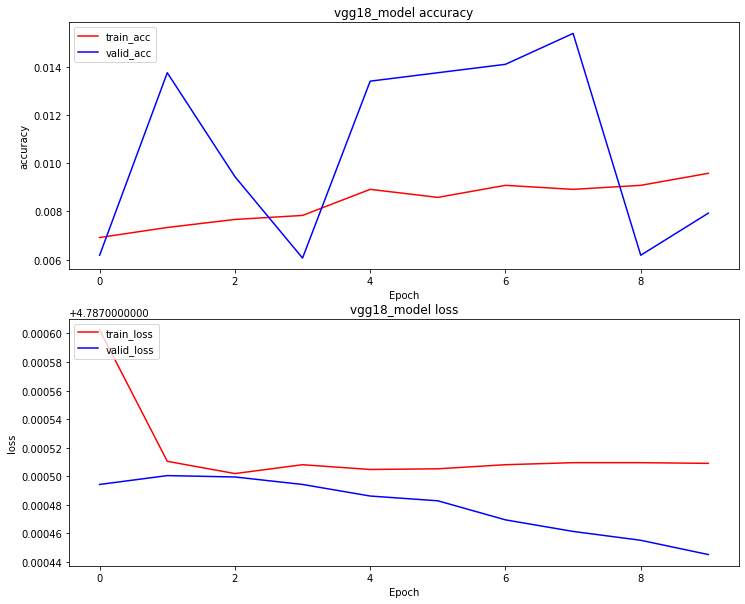

In [13]:
## 모델 결과 시각화
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(history_vgg18_model_05.history['accuracy'], 'r', label="train_acc")
plt.plot(history_vgg18_model_05.history['val_accuracy'], 'b', label="valid_acc")
plt.title('vgg18_model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(2,1,2)
plt.plot(history_vgg18_model_05.history['loss'], 'r', label="train_loss")
plt.plot(history_vgg18_model_05.history['val_loss'], 'b', label="valid_loss")
plt.title('vgg18_model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

In [14]:
import json

def vgg18_history_loader(history):
    """
    저장된 학습 기록(history)을 변환하여 특정 키와 값을 추출한 후 반환.
    """
    return_history = {
        'loss': list(history['loss']),
        'accuracy': list(history['accuracy']),
        'val_loss': list(history['val_loss']),
        'val_accuracy': list(history['val_accuracy']),
    }
    return return_history

# 저장된 파일 불러오기
history_path = 'history/history_vgg18_model.json'

with open(history_path, 'r') as f:
    history_vgg18_model = json.load(f)

# vgg18_history_loader 함수 적용
history_vgg18_model = vgg18_history_loader(history_vgg18_model)

# 변환된 학습 기록 출력
print("변환된 학습 기록:")
print(history_vgg18_model)

변환된 학습 기록:
{'loss': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'accuracy': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'val_loss': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'val_accuracy': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']}


---
---
---

In [15]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def build_vgg50(input_shape=(224, 224, 3), num_classes=120):
    inputs = Input(shape=input_shape)

    # Helper function to create repeated Conv2D layers
    def add_conv_block(x, num_filters, num_convs):
        for _ in range(num_convs):
            x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
        return x

    # Block 1
    x = add_conv_block(inputs, 64, 4)  # 4 Convolution layers
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 2
    x = add_conv_block(x, 128, 4)  # 4 Convolution layers
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 3
    x = add_conv_block(x, 256, 8)  # 8 Convolution layers
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4
    x = add_conv_block(x, 512, 14)  # 14 Convolution layers
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 5
    x = add_conv_block(x, 512, 14)  # 14 Convolution layers
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Global Average Pooling Layer
    x = GlobalAveragePooling2D()(x)

    # Dense Layer for classification
    outputs = Dense(num_classes, activation='softmax', use_bias=False)(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# VGG50 모델 생성
vgg50_model = build_vgg50(input_shape=(224, 224, 3), num_classes=120)

# 모델 요약 출력 (필요 시)
vgg50_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 112, 112, 128)     7385

In [16]:
# 학습하기
vgg50_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_vgg50_model = vgg50_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
322/750 [===========>..................] - ETA: 4:45 - loss: 4.7876 - accuracy: 0.0056

KeyboardInterrupt: 

In [ ]:
# 학습 기록(history) 저장
import json
import pandas as pd
history_path = 'history/history_vgg50_model.json'

with open(history_path, 'w') as f:
    pd.DataFrame(history_vgg50_model.history).to_json(f)

print(f"학습 기록이 저장되었습니다: {history_path}")

In [ ]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# 저장 경로 설정
base_dir = '/aiffel/class_activation_map'
vgg50_model_path = os.path.join(base_dir, 'vgg50_model.h5')
weights_path = os.path.join(base_dir, 'vgg50_model_weights.h5')
checkpoint_path = os.path.join(base_dir, 'vgg50_model_checkpoint.h5')

# 모델 및 가중치 저장
vgg50_model.save(vgg50_model_path)  # 모델 전체 저장
vgg50_model.save_weights(weights_path)  # 가중치만 별도로 저장

# 체크포인트 저장
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,  # 체크포인트 파일 경로
    save_best_only=True,       # 가장 좋은 성능의 가중치만 저장
    save_weights_only=False,   # 모델 전체를 저장 (구조 + 가중치)
    verbose=1
)

print(f"모델 전체가 저장되었습니다: {vgg50_model_path}")
print(f"모델 가중치가 저장되었습니다: {weights_path}")
print(f"체크포인트 파일이 저장되었습니다: {checkpoint_path}")

In [ ]:
## 모델 결과 시각화
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(history_vgg50_model.history['accuracy'], 'r', label="train_acc")
plt.plot(history_vgg50_model.history['val_accuracy'], 'b', label="valid_acc")
plt.title('vgg50_model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(2,1,2)
plt.plot(history_vgg50_model.history['loss'], 'r', label="train_loss")
plt.plot(history_vgg50_model.history['val_loss'], 'b', label="valid_loss")
plt.title('vgg50_model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

In [ ]:
import json

def vgg50_history_loader(history):
    """
    저장된 학습 기록(history)을 변환하여 특정 키와 값을 추출한 후 반환.
    """
    return_history = {
        'loss': list(history['loss']),
        'accuracy': list(history['accuracy']),
        'val_loss': list(history['val_loss']),
        'val_accuracy': list(history['val_accuracy']),
    }
    return return_history

# 저장된 파일 불러오기
history_path = 'history/history_vgg50_model.json'

with open(history_path, 'r') as f:
    history_vgg50_model = json.load(f)

# vgg50_history_loader 함수 적용
history_vgg50_model = vgg50_history_loader(history_vgg50_model)

# 변환된 학습 기록 출력
print("변환된 학습 기록:")
print(history_vgg50_model)